In [303]:
from typing import List
import re
from math import log
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [304]:
def matching_graph(d: int, probabilities: List[float]) -> nx.Graph:
    """Get the matching graph for the repetition code.
    
    Arguments:
    d - Distance of the code. Should be odd.
    probabilities - A list of bit-flip probablities.
    
    Returns:
    M - The matching graph for this code and error model."""

    assert d >= 3, f"Distance must be >= 3, but got {d}."
    assert d % 2 != 0, f"Distance d must be odd, but got {d}."

    matching_graph = nx.Graph()
    # First add the "extra nodes" for the leftmost and rightmost qubits.
    matching_graph.add_node("r1")
    matching_graph.add_node("r2")
    # Then add the regular syndromes
    for i in range(d - 1):
        matching_graph.add_node(f"s{i}")
    # Add an edge of weight w = log((1-p_i)/p_i) for each qubit.
    for i in range(d):
        w = log((1. - probabilities[i]) / probabilities[i])
        if i == 0:
            matching_graph.add_edge("r1", "s0", weight=w, label="q0")
        elif i == d - 1:
            matching_graph.add_edge("r2", f"s{i-1}", weight=w, label=f"q{i}")
        else:
            matching_graph.add_edge(f"s{i-1}", f"s{i}", weight=w, label=f"q{i}")
    return matching_graph

In [305]:
def error_to_syndrome(err: np.ndarray) -> np.ndarray:
    """Convert a list of bit-flips into a the repetition code syndrome."""

    d = err.size
    check = np.zeros((d-1, d), dtype=bool)
    for i in range(d - 1):
        check[i, i] = True
        check[i, i + 1] = True
    return ((check.astype(int) @ err.astype(int)) % 2).astype(bool)

In [306]:
def syndrome_graph(matching: nx.Graph, syndrome: np.ndarray) -> nx.Graph:
    """Gets the syndrome graph for a binary syndrome vector given the
    matching graph."""

    d = len(matching.nodes()) - 1
    assert syndrome.size == d - 1

    syndrome_nodes: List[str] = []
    for i, b in enumerate(syndrome):
        if b:
            syndrome_nodes.append(f"s{i}")
            if i == 0:
                if not syndrome[1]:
                    syndrome_nodes.append("r1")
            if i == len(syndrome) - 1:
                if not syndrome[-2]:
                    syndrome_nodes.append("r2")
    # Build a graph with a node for each 1 in the syndrome.
    # The weight between two nodes will be the distance on the matching graph.
    syndrome_gr = nx.Graph()
    for snode in syndrome_nodes:
        syndrome_gr.add_node(snode)
    assert set(syndrome_gr.nodes()).issubset(matching.nodes())
    for sn1 in syndrome_gr.nodes():
        for sn2 in syndrome_gr.nodes():
            if sn1 != sn2:
                length = nx.shortest_path_length(matching, sn1, sn2, weight='weight')
                syndrome_gr.add_edge(sn1, sn2, weight=length)
    return syndrome_gr

In [307]:
def repetition_tanner_graph(d: int) -> nx.Graph:
    """Get the Tanner graph for a repetition code."""

    assert d % 2 != 0
    assert d >= 3

    tanner_graph = nx.Graph()
    for i in range(d):
        tanner_graph.add_node(f"q{i}")
        if i == 0:
            tanner_graph.add_node(f"r1")
            tanner_graph.add_node(f"s0")
            tanner_graph.add_edge("q0", "r1")
            tanner_graph.add_edge("q0", "s0")
        elif i == d - 1:
            tanner_graph.add_node("r2")
            tanner_graph.add_edge(f"q{i}", "r2")
            tanner_graph.add_edge(f"q{i}", f"s{i - 1}")
        else:
            tanner_graph.add_node(f"s{i}")
            tanner_graph.add_edge(f"q{i}", f"s{i - 1}")
            tanner_graph.add_edge(f"q{i}", f"s{i}")
    return tanner_graph

In [308]:
def matching_to_correction(matching, tanner_graph) -> np.ndarray:
    """Convert the minimum-weight matching to a binary correction."""

    # Count qubits in the Tanner graph.
    nq = 0
    for node in tanner_graph.nodes():
        if 'q' in node:
            nq += 1

    correction = [False] * nq
    for n1, n2 in matching:
        n1_neighbors = tanner_graph.neighbors(n1)
        n2_neighbors = tanner_graph.neighbors(n2)
        common_qubits = set(n1_neighbors) & set(n2_neighbors)
        assert len(common_qubits) == 1
        qubit_node_name = list(common_qubits)[0]
        idx = int(re.search(r'\d+', qubit_node_name).group()) 
        correction[idx] = True
    return np.array(correction)

In [ ]:
d = 5
probs = [0.1] * d
# TODO this case should not have a dummy!
err = np.array([False, True, True, False, False])
syndrome = error_to_syndrome(err)
print(f"syndrome = {syndrome}")

tanner_graph = repetition_tanner_graph(d)
matching_gr = matching_graph(d, probs)
syndrome_gr = syndrome_graph(matching_gr, syndrome)
print(f"syndrome graph nodes: {syndrome_gr.nodes()}")
matching = nx.min_weight_matching(syndrome_gr)
print("matching =", matching)
correction = matching_to_correction(matching, tanner_graph)
print(f"correction = {correction}")
print(correction ^ err)

syndrome = [ True False  True False]
syndrome graph nodes: ['s0', 'r1', 's2']
matching = {('r1', 's0')}
correction = [ True False False False False]
[ True  True  True False False]


{'q0': Text(-0.06194707775286194, 0.8540005643619544, 'q0'),
 'r1': Text(0.05581608073626282, 1.0, 'r1'),
 's0': Text(-0.15771261081658897, 0.6804704220979644, 's0'),
 'q1': Text(-0.16713398432147203, 0.45374393019440606, 'q1'),
 's1': Text(-0.1345088435193967, 0.21178446518019906, 's1'),
 'q2': Text(-0.132458988437099, -0.03769366798649224, 'q2'),
 's2': Text(-0.12352233010606765, -0.2882545108264377, 's2'),
 'q3': Text(-0.062235247358432014, -0.5228925200367758, 'q3'),
 's3': Text(0.0757213522239011, -0.7047136913349665, 's3'),
 'q4': Text(0.2707443335641741, -0.769034597569734, 'q4'),
 'r2': Text(0.43723731578758057, -0.8774103940801177, 'r2')}

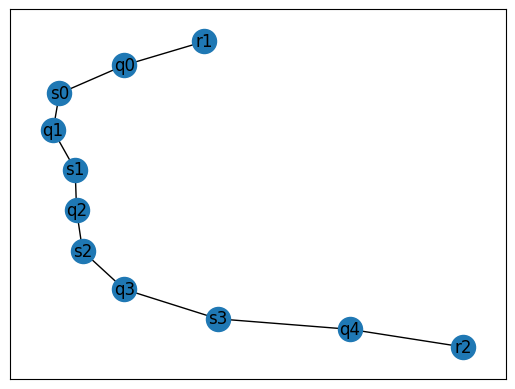

In [310]:
plt.figure()
pos = nx.spring_layout(tanner_graph)
nx.draw_networkx_nodes(tanner_graph, pos)
nx.draw_networkx_edges(tanner_graph, pos)
nx.draw_networkx_labels(tanner_graph, pos)

{'r1': Text(-1.0, 0.1861524792270329, 'r1'),
 'r2': Text(0.9999153977665891, -0.1769262034368337, 'r2'),
 's0': Text(-0.6373871111144989, 0.11570150203120906, 's0'),
 's1': Text(-0.21506962789492162, 0.034986155072419034, 's1'),
 's2': Text(0.2147530688669232, -0.0433767077431405, 's2'),
 's3': Text(0.6377882723759075, -0.11653722515068696, 's3')}

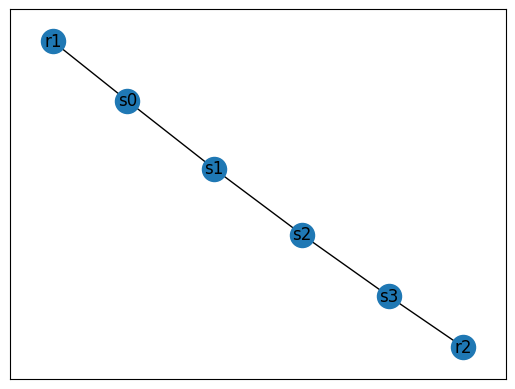

In [311]:
plt.figure()
pos = nx.spring_layout(matching_gr)
nx.draw_networkx_nodes(matching_gr, pos)
nx.draw_networkx_edges(matching_gr, pos)
nx.draw_networkx_labels(matching_gr, pos)

{'s0': Text(-0.34916080452341003, -0.9999999999999999, 's0'),
 'r1': Text(0.8362548350878286, 0.4927571275938284, 'r1'),
 's2': Text(-0.4870940305644191, 0.5072428724061708, 's2')}

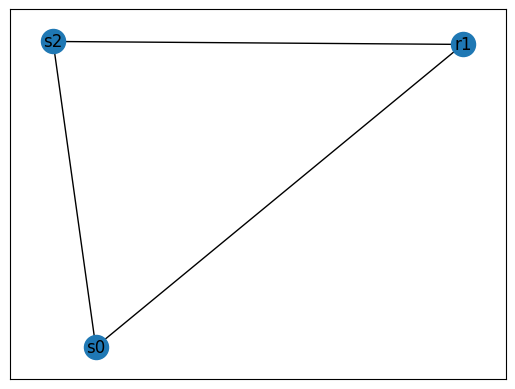

In [312]:
plt.figure()
pos = nx.spring_layout(syndrome_gr)
nx.draw_networkx_nodes(syndrome_gr, pos)
nx.draw_networkx_edges(syndrome_gr, pos)
nx.draw_networkx_labels(syndrome_gr, pos)